In [3]:
# Basic Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.signal

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [4]:
# Libraries for Classification and building Models
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [5]:
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 

###  MFCC

In [6]:
# Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa

audio_dataset_path='audio/'
metadata=pd.read_csv('metadata/ff1010bird_metadata_2018.csv')
metadata.head()

,itemid,datasetid,fold,hasbird
0,55.wav,ff1010bird,1,0
1,87.wav,ff1010bird,1,0
2,99.wav,ff1010bird,1,0
3,100.wav,ff1010bird,1,1
4,104.wav,ff1010bird,1,0


In [7]:
N_MELS = 40
FFT_POINTS = 882 * 2
SR = 44100
HAMMING_SIGNAL = scipy.signal.hamming
FRAMES = 500


In [8]:
# creating a function that extracts and lable the file 
# normalising the audio 

def feature_extract(audio_dataset_path, data_fold, data_id, data_labels):
    feature_file = []
    label_file = []

    for i in range(len(data_id)):
        #file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold'+str(row["fold"])+'/',str(row["itemid"]))
        file_name = audio_dataset_path + 'fold' + str(data_fold[i]) + '/' + str(data_id[i])
        [wave, _] = librosa.core.load(file_name ,sr=SR)  # read wav file (fs = 44.1 kHz)
        wave = librosa.stft(wave, FFT_POINTS, win_length=FFT_POINTS,
                            window=HAMMING_SIGNAL)  # STFT computation (fft_points = 882*2, overlap= 50%, analysis_window=40ms)
        wave = np.abs(wave) ** 2
        spectrogram = librosa.feature.melspectrogram(S=wave, n_mels=N_MELS)  # mel bands (40)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        norm_spectrogram = spectrogram - np.amin(spectrogram)
        norm_spectrogram = norm_spectrogram / float(np.amax(norm_spectrogram))

        if int(norm_spectrogram.shape[1]) < FRAMES:  # 10 sec samples gives 500 frames
            z_pad = np.zeros((N_MELS, FRAMES))
            z_pad[:, :-(FRAMES - norm_spectrogram.shape[1])] = norm_spectrogram
            feature_file.append(z_pad)
        else:
            img = norm_spectrogram[:, np.r_[0:FRAMES]]  # final_shape = 40*500
            feature_file.append(img)

        if len(data_labels) > 0:
            label_file.append(data_labels[i])

    feature_file = np.array(feature_file)
    feature_file = np.reshape(feature_file, (len(data_id), N_MELS, FRAMES, 1))

    if len(data_labels) > 0:  # In case of training data
        label_file = np.array(label_file)
        return feature_file, label_file
    else:  # In case of testing data
        return feature_file

In [9]:
#load the extracted feautures
X= np.load('features_data_X.npy')
y= np.load('features_data_y.npy')

In [10]:
X.shape

(15690, 40, 500, 1)

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [12]:
y.shape

(15690, 2)

### Splitting dataset 

In [13]:
#splitting the dataset to training and validation
X_trainset, X_val, y_trainset, y_val = train_test_split(X, y, random_state = 1)

In [14]:
X_trainset.shape

(11767, 40, 500, 1)

In [15]:
X_val.shape

(3923, 40, 500, 1)

In [16]:
# splitting the training dataset to obtain some test set for the testing phase
X_train, X_test, y_train, y_test = train_test_split(X_trainset, y_trainset, random_state = 1)

In [17]:
X_train.shape

(8825, 40, 500, 1)

In [18]:
X_test.shape

(2942, 40, 500, 1)

In [19]:
X_val.shape

(3923, 40, 500, 1)

In [20]:
input_dim = (40, 500, 1)

### CNN Model

In [21]:
model = Sequential()
model.add(Conv2D(48, kernel_size=3, activation='relu', input_shape=input_dim))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(48, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(96, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(96, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(384, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))

In [24]:
optimizer = tf.keras.optimizers.Adam(lr=3e-4)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 498, 48)       480       
                                                                 
 batch_normalization (BatchN  (None, 38, 498, 48)      192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 38, 498, 48)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 249, 48)       57648     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 249, 48)      192       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 19, 249, 48)       0

In [26]:
def data_augmentation():
    gen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
    return gen

In [27]:
gen = data_augmentation()

In [28]:
#adding the learning rate
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [29]:
callback = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
            keras.callbacks.ModelCheckpoint(filepath='saved_models/audio_classification2.hdf5', monitor='val_loss', verbose=1,
                                            save_best_only=True),
            keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.7 ** x),
            keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)]

In [30]:
EPOCHS = 50

In [31]:
hist = model.fit(gen.flow(X_train, y_train, batch_size=64),
                              epochs=EPOCHS,
                              steps_per_epoch=X_train.shape[0] // 64,
                              validation_data=(X_test, y_test),
                              callbacks=callback,
                              verbose=1)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0003000000142492354.
Epoch 1/50
137/137 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.6431
Epoch 00001: val_loss improved from inf to 1.00749, saving model to data/MyDrive/ffbirds-CNN/saved_models/audio_classification2.hdf5
137/137 [==============================] - 104s 511ms/step - loss: 0.7966 - accuracy: 0.6431 - val_loss: 1.0075 - val_accuracy: 0.5126 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7029
Epoch 00002: val_loss did not improve from 1.00749
137/137 [==============================] - 60s 435ms/step - loss: 0.6357 - accuracy: 0.7029 - val_loss: 1.2041 - val_accuracy: 0.5126 - lr: 7.0000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.000699999975040555.
Epoch 3/50
137/137 [==============================] - ETA: 0s - loss: 0.57

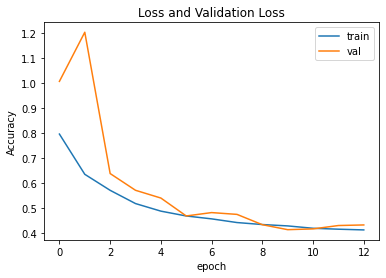

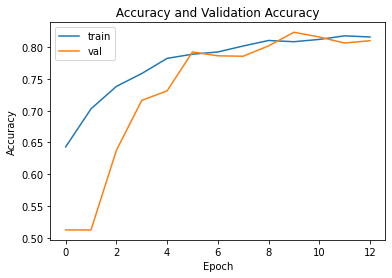

In [32]:
#plot graph

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Loss and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title(' Accuracy and Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();
plt.show()

In [33]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 10 samples")
predictions = model.predict(X_test[:10])
print("predictions shape:", predictions.shape)

Evaluate on test data
46/46 [==============================] - 7s 154ms/step - loss: 0.4330 - accuracy: 0.8100
test loss, test acc: [0.43300890922546387, 0.8099932074546814]
Generate predictions for 10 samples
predictions shape: (10, 2)
